In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import logging
import argparse
import glob
import json
from multiprocessing import Pool

import numpy as np
import matplotlib
from matplotlib.ticker import StrMethodFormatter, FormatStrFormatter
from scipy import stats, integrate
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown
import statsmodels.api as sm

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses, dirichlet_stats
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config
from zoobot.active_learning import acquisition_utils
from zoobot import label_metadata

In [4]:
os.chdir('/home/walml/repos/zoobot')

In [5]:
questions = label_metadata.decals_questions
version='decals'
label_cols = label_metadata.decals_label_cols
schema = losses.Schema(label_cols, questions, version=version)

{smooth-or-featured, indices 0 to 2, asked after None: (0, 2), disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1: (3, 4), has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4: (5, 6), bar, indices 7 to 9, asked after disk-edge-on_no, index 4: (7, 9), bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4: (10, 14), how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0: (15, 17), edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3: (18, 20), spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5: (21, 23), spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5: (24, 29), merging, indices 30 to 33, asked after None: (30, 33)}


In [6]:

# catalog_loc = 'data/decals/decals_master_catalog.csv'
# catalog = pd.read_csv(catalog_loc, dtype={'subject_id': str})  # original catalog
# # catalog['file_loc'] = catalog['local_png_loc'].apply(lambda x: '/media/walml/beta/gz2' + x[32:])
# catalog['file_loc'] = catalog['local_png_loc'].apply(lambda x: '/media/walml/beta/decals' + x.replace('/data/phys-zooniverse/chri5177', ''))

In [18]:


df_a = pd.read_csv('results/decals_dr_full_m1_eval_predictions.csv')
df_b = pd.read_csv('results/decals_dr_full_m2_eval_predictions.csv')
df_c = pd.read_csv('results/decals_dr_full_m0_eval_predictions.csv')

df_a = df_a.sort_values('id_str')
df_b = df_b.sort_values('id_str')
df_c = df_c.sort_values('id_str')

df_a['file_loc'] = df_a['local_png_loc'].apply(lambda x: '/media/walml/beta/decals' + x.replace('/data/phys-zooniverse/chri5177', ''))
df_b['file_loc'] = df_b['local_png_loc'].apply(lambda x: '/media/walml/beta/decals' + x.replace('/data/phys-zooniverse/chri5177', ''))
df_c['file_loc'] = df_c['local_png_loc'].apply(lambda x: '/media/walml/beta/decals' + x.replace('/data/phys-zooniverse/chri5177', ''))


In [19]:
eval_df = pd.read_csv('results/decals_dr_full_eval_df.csv')
id_strs = set(eval_df['id_str'])

# in eval df
df_a = df_a[df_a['id_str'].isin(id_strs)]
df_b = df_b[df_b['id_str'].isin(id_strs)]
df_c = df_c[df_c['id_str'].isin(id_strs)]

# only featured for now
# df_a = df_a[df_a['smooth-or-featured_featured-or-disk_fraction'] > 0.5]
# df_b = df_b[df_b['smooth-or-featured_featured-or-disk_fraction'] > 0.5]
# df_c = df_c[df_c['smooth-or-featured_featured-or-disk_fraction'] > 0.5]

# # not edge on disk for now
# df_a = df_a[df_a['disk-edge-on_no'] > 0.5]
# df_b = df_b[df_b['disk-edge-on_no'] > 0.5]
# df_c = df_c[df_c['disk-edge-on_no'] > 0.5]

prediction_dfs = [df_a, df_b, df_c]

In [20]:
# adapted from performance_metrics.ipynb
# several models (ensemble)
# concentration_cols = [a.text + '_concentration' for a in schema.answers
question = schema.questions[0]
concentration_cols = [a.text + '_concentration' for a in question.answers]
samples = []
for df in prediction_dfs:
    model_samples = dirichlet_stats.load_all_concentrations(df, concentration_cols=concentration_cols)
    samples.append(model_samples)
samples = np.concatenate(samples, axis=2)
samples.shape

(49700, 3, 15)

In [ ]:
import tensorflow as tf

In [39]:
# expected_votes = tf.constant((df_a['smooth-or-featured_total-votes']), dtype=tf.float64)
samples_for_q = samples  # loaded only for the q I want
expected_votes = tf.ones(len(samples), dtype=tf.float64) * 5

In [40]:
acquisition_utils.dirichlet_expected_entropy_per_model(
    samples_for_q[:10], expected_votes[:10]
)

array([1.87777737, 1.76887834, 1.05966936, 2.06832642, 1.93322126,
       2.00182691, 2.38671328, 1.21325175, 2.17337658, 2.29293   ])

In [41]:
entropies = acquisition_utils.dirichlet_expected_entropy_per_model(
    samples_for_q[:1000], expected_votes[:1000]
)

In [52]:
entropies = acquisition_utils.dirichlet_expected_entropy_per_model(
    samples_for_q[:10000], expected_votes[:10000]
)

In [53]:
df = df_a[:10000]
df['entropy'] = entropies

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [134]:
def show_galaxies(df, n_rows=5, n_cols=2):
    scale = 3
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(scale * n_cols * 0.97, scale * n_rows), gridspec_kw={'hspace': 0.02, 'wspace':0.02})
    all_axes = [ax for row in axes for ax in row]
    for galaxy_n in range(n_rows * n_cols):
        galaxy = df.iloc[galaxy_n]
        ax = all_axes[galaxy_n]
        image = Image.open(galaxy['file_loc'])
        ax.imshow(image)
        ax.axis('off')
    fig.tight_layout()

In [135]:
!pwd

/home/walml/repos/zoobot


/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # This is added back by InteractiveShellApp.init_path()


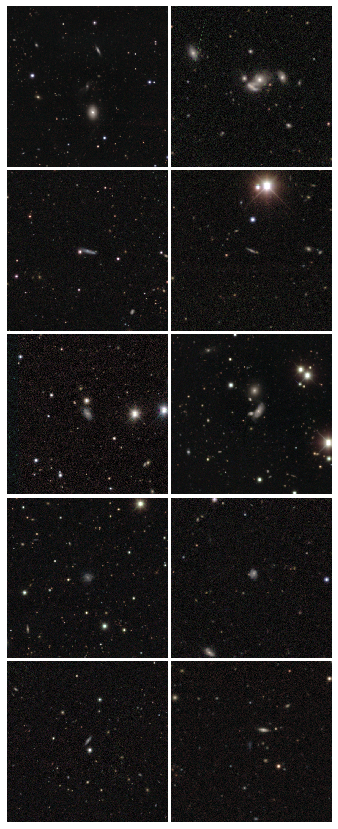

In [136]:
show_galaxies(df.sort_values('entropy', ascending=False))
plt.savefig('notebooks/multiq/most_uncertain_10k_test_smooth_feat.png')
plt.savefig('notebooks/multiq/most_uncertain_10k_test_smooth_feat.pdf')

In [182]:
# copied from touch table
def quality_check(df, n_bins=4, n_galaxies_per_bin=5):

#     df['binned_acq'], bins = pd.cut(df['acquisition'], n_bins, labels=False, retbins=True)
    df['binned_entropy'], bins = pd.cut(df['entropy'], n_bins, labels=False, retbins=True)
#     df['binned_entropy'], bins = pd.qcut(df['entropy'], n_bins, labels=False, retbins=True)
#     print(bins)
#     print(df['binned_entropy'].value_counts())
    
    scale = 3
    plt.figure(figsize=(scale * n_galaxies_per_bin * 0.52, scale * n_bins))
    gs1 = gridspec.GridSpec(n_galaxies_per_bin + 1, n_bins)
    gs1.update(wspace=0.0, hspace=0.0)
    for bin_n in range(n_bins):
        selected_df = df.query('binned_entropy == {}'.format(bin_n))
        selected_df = selected_df.sample(len(selected_df))  # shuffle
        for galaxy_n in range(n_galaxies_per_bin):
            if galaxy_n < len(selected_df):
                galaxy = selected_df.iloc[galaxy_n]
                image = Image.open(galaxy['file_loc'])
                ax = plt.subplot(gs1[galaxy_n+1, bin_n])
                ax.imshow(image)
#                 ax.text(50, 50, 'Spiral = {:.2f}'.format(galaxy['has-spiral-arms_fraction']), fontsize=16, color='r')
#                 ax.text(50, 120, 'N = {}'.format(galaxy['total']), fontsize=16, color='r')
                if galaxy_n == 0:
                    ax.text(40, -50, '{:.2f} - {:.2f}'.format(bins[bin_n], bins[bin_n + 1]), fontsize=16, color='black')
                    if bin_n == 0:
                        ax.text(730, -150, 'Entropy')
                ax.axis('off')
    return df

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


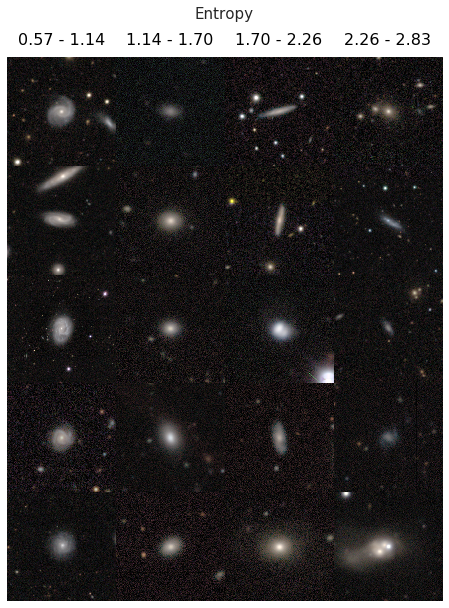

In [183]:
_ = quality_check(df)
# plt.savefig('notebooks/multiq/binned_uncertain_10k_test_smooth_feat.png')
# plt.savefig('notebooks/multiq/binned_uncertain_10k_test_smooth_feat.pdf')

In [47]:
sns.set(font_scale=1.25, context='notebook')
sns.set_style('ticks')